# <center>手写数字分类识别入门体验</center>

## 实现一个图片分类应用
## 概述
下面我们通过一个实际样例，带领大家体验MindSpore基础的功能，对于一般的用户而言，完成整个样例实践会持续20~30分钟。

本例子会实现一个简单的图片分类的功能，整体流程如下：

1. 处理需要的数据集，这里使用了MNIST数据集。

2. 定义一个网络，这里我们使用LeNet网络。

3. 自定义回调函数收集模型的损失值和精度值。

4. 加载数据集并进行训练，训练完成后，查看结果及保存模型文件。

5. 加载保存的模型，进行推理。

6. 验证模型，加载测试数据集和训练后的模型，验证结果精度。

> 本文档适用于CPU、GPU和Ascend环境。

## 训练的数据集下载

直接执行下面代码，会自动进行训练集的下载与解压。

In [1]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
!unzip -o MNIST_Data.zip -d ./datasets
!tree ./datasets/MNIST_Data/

--2020-11-30 16:41:42--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10754903 (10M) [application/zip]
Saving to: ‘MNIST_Data.zip’

MNIST_Data.zip      100%[===================>]  10.26M  --.-KB/s    in 0.06s   

2020-11-30 16:41:42 (185 MB/s) - ‘MNIST_Data.zip’ saved [10754903/10754903]

Archive:  MNIST_Data.zip
   creating: MNIST_Data/test/
  inflating: MNIST_Data/test/t10k-images-idx3-ubyte  
  inflating: MNIST_Data/test/t10k-labels-idx1-ubyte  
   creating: MNIST_Data/train/
  inflating: MNIST_Data/train/train-images-idx3-ubyte  
  inflating: MNIST_Data/train/train-labels-idx1-ubyte  
./datasets/MNIST_Data/
├── test
│   ├── t10k-images-idx3-ubyte
│  

## 处理MNIST数据集

由于我们后面会采用LeNet这样的卷积神经网络对数据集进行训练，而采用LeNet在训练数据时，对数据格式是有所要求的，所以接下来的工作需要我们先查看数据集内的数据是什么样的，这样才能构造一个针对性的数据转换函数，将数据集数据转换成符合训练要求的数据形式。

### 查看原始数据集数据

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 2


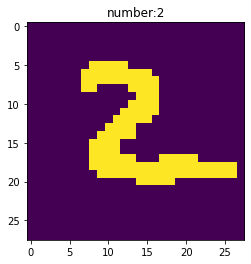

In [2]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE, device_target="CPU") 
train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape) 
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

从上面的运行情况我们可以看到，训练数据集`train-images-idx3-ubyte`和`train-labels-idx1-ubyte`对应的是6万张图片和6万个数字下标，载入数据后经过`create_dict_iterator`转换字典型的数据集，取其中的一个数据查看，这是一个key为`image`和`label`的字典，其中的`image`的张量(高度28，宽度28，通道1)和`label`为对应图片的数字。

### 数据处理

数据集对于训练非常重要，好的数据集可以有效提高训练精度和效率，在加载数据集前，我们通常会对数据集进行一些处理。

#### 定义数据集及数据操作

我们定义一个函数`create_dataset`来创建数据集。在这个函数中，我们定义好需要进行的数据增强和处理操作：

1. 定义数据集。
2. 定义进行数据增强和处理所需要的一些参数。
3. 根据参数，生成对应的数据增强操作。
4. 使用`map`映射函数，将数据操作应用到数据集。
5. 对生成的数据集进行处理。

定义完成后，使用`create_datasets`对原始数据进行增强操作，并抽取一个`batch`的数据，查看数据增强后的变化。

In [3]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ 
    create dataset for train or test
    
    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    
    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

Number of groups in the dataset: 1875


上述增强过程中：
- 数据集中的`label`数据增强操作：
    - `C.TypeCast`：对数据类型转化为`int32`。
- 数据集中的`image`数据增强操作：
    - `datasets.MnistDataset`：将数据集转化为MindSpore可训练的数据。 
    - `CV.Resize`：对图像数据像素进行缩放，适应LeNet5网络对数据的尺寸要求。
    - `CV.Rescale`：对图像数据进行标准化，归一化操作，使得每个像素的数值大小在范围（0,1）中，可以提升训练效率。
    - `CV.HWC2CHW`：对图像数据张量进行变换，张量形式由高x宽x通道（HWC）变为通道x高x宽（CHW），方便进行数据训练。
- 其他增强操作：
    - `mnist_ds.shuffle`：本例中表示随机将数据存放在可容纳10000张图片地址的内存中进行混洗。
    - `mnist_ds.batch`：本例中表示从混洗的10000张图片地址中抽取32张图片组成一个`batch`。
    - `mnist_ds.repeat`：将`batch`数据进行复制增强。

> 先进行`shuffle`、`batch`操作，再进行`repeat`操作，这样能保证1个`epoch`内数据不重复。

调用数据增强函数后，查看数据集`size`由60000变成了1875，符合我们的数据增强中`mnist_ds.batch`操作的预期（$60000/32=1875$）。

#### 进一步查看增强后的数据

从1875组数据中取出一组数据查看其数据张量及`label`。

In [4]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('labels:', labels)

Tensor of image: (32, 1, 32, 32)
labels: [1 9 6 9 4 1 0 3 3 7 7 1 7 5 7 4 7 3 0 8 5 3 3 9 6 3 7 8 2 3 8 1]


将张量数据和下标对应的值进行可视化。

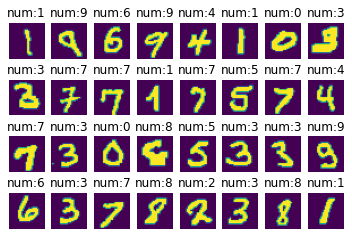

In [5]:
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

通过上述查询操作，看到经过变换后的图片，数据集内分成了1875组数据，每组数据中含有32张图片，每张图片像数值为32×32，数据全部准备好后，就可以进行下一步的数据训练了。

## 构造神经网络

在对手写字体识别上，通常采用卷积神经网络架构（CNN）进行学习预测，最经典的属1998年由Yann LeCun创建的LeNet5架构，<br/>其中分为：<br/>1、输入层；<br/>2、卷积层C1；<br/>3、池化层S2；<br/>4、卷积层C3；<br/>5、池化层S4；<br/>6、全连接F6；<br/>7、全连接；<br/>8、全连接OUTPUT。<br/>结构示意如下图：

### LeNet5结构图

<img src="https://gitee.com/mindspore/docs/raw/r1.1/tutorials/training/source_zh_cn/quick_start/images/LeNet_5.jpg" alt="LeNet5">

更多的LeNet网络的介绍不在此赘述，希望详细了解LeNet网络，可以查询<http://yann.lecun.com/exdb/lenet/>。

在构建LeNet5前，我们需要对全连接层以及卷积层进行初始化。

`Normal`：参数初始化方法，MindSpore支持`TruncatedNormal`、`Normal`、`Uniform`等多种参数初始化方法，具体可以参考MindSpore API的`mindspore.common.initializer`模块说明。



使用MindSpore定义神经网络需要继承`mindspore.nn.Cell`，`Cell`是所有神经网络（`Conv2d`等）的基类。

神经网络的各层需要预先在`__init__`方法中定义，然后通过定义`construct`方法来完成神经网络的前向构造，按照LeNet5的网络结构，定义网络各层如下：

In [6]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x
    
network = LeNet5()
print("layer conv1:", network.conv1)
print("*"*40)
print("layer fc1:", network.fc1)

layer conv1: Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False,weight_init=normal, bias_init=zeros>
****************************************
layer fc1: Dense<in_channels=400, out_channels=120, weight=Parameter (name=fc1.weight, value=[[-0.00758117 -0.01498233  0.01308791 ...  0.03045311 -0.00079244
  -0.01519072]
 [-0.00077699 -0.01607893 -0.00215094 ... -0.00235667 -0.01918699
  -0.00828544]
 [-0.00105981 -0.01547002 -0.01332507 ...  0.01294748  0.00878882
   0.01031067]
 ...
 [ 0.01414873 -0.02673322  0.01534838 ...  0.00437457 -0.01688845
  -0.00188475]
 [ 0.01756713 -0.0201801  -0.0223504  ...  0.00682346 -0.00856738
   0.00753205]
 [-0.01119993  0.01894077 -0.02048291 ...  0.03681218 -0.01461048
   0.0045935 ]]), has_bias=True, bias=Parameter (name=fc1.bias, value=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

构建完成后，可以使用`print(LeNet5())`将神经网络中的各层参数全部打印出来，也可以使用`LeNet().{layer名称}`打印相应的参数信息。本例选择打印第一个卷积层和第一个全连接层的相应参数。

## 自定义回调函数收集模型的损失值和精度值

自定义一个收集每一步训练的`step`，每训练一个`step`模型对应的`loss`值，每训练25个`step`模型对应的验证精度值`acc`的类`StepLossAccInfo`，该类继承了`Callback`类，可以自定义训练过程中的处理措施，非常方便，等训练完成后，可将数据绘图查看`step`与`loss`的变化情况，step与acc的变化情况。

参数解释如下：

- `model`：函数的模型Model。
- `eval_dataset`：验证数据集。
- `step_loss`：收集step和loss值的字典，数据格式`{"step": [], "loss_value": []}`。
- `steps_eval`：收集step和模型精度值的字典，数据格式为`{"step": [], "acc": []}`。

以下代码在会作为回调函数，在模型训练函数`model.train`中调用，用于收集训练过程中step数和相对应的loss值、精度值等信息，最终使用收集到的信息，进行可视化展示。

In [7]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, step_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.step_loss = step_loss
        self.steps_eval = steps_eval
        
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.step_loss["loss_value"].append(str(cb_params.net_outputs))
        self.step_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])
            

## 搭建训练网络并进行训练

构建完成神经网络后，就可以着手进行训练网络的构建，模型训练函数为`Model.train`，参数主要包含：
1. 每个`epoch`需要遍历完成图片的`batch`数：`epoch_size`；
2. 数据集`ds_train`；
3. 回调函数`callbacks`包含`ModelCheckpoint`、`LossMonitor`和`Callback`模型检测参数；
4. 数据下沉模式`dataset_sink_mode`，此参数默认`True`需设置成`False`，因为此功能不支持CPU模式。

### 定义损失函数及优化器

在进行定义之前，先简单介绍损失函数及优化器的概念。

损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有`SoftmaxCrossEntropyWithLogits`、`L1Loss`、`MSELoss`等。这里使用`SoftmaxCrossEntropyWithLogits`损失函数。

In [8]:
import os
from mindspore import Tensor, Model
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

lr = 0.01
momentum = 0.9 
epoch_size = 1
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_quick_start/"

# clean up old run files before in Linux
os.system('rm -f {}*.ckpt {}*.meta {}*.pb'.format(model_path, model_path, model_path))

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)


eval_dataset = create_dataset("./datasets/MNIST_Data/test")

step_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, step_loss, steps_eval)

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)

epoch: 1 step: 125, loss is 2.3114552
epoch: 1 step: 250, loss is 2.2977211
epoch: 1 step: 375, loss is 2.2881548
epoch: 1 step: 500, loss is 2.3017395
epoch: 1 step: 625, loss is 2.28271
epoch: 1 step: 750, loss is 2.2940521
epoch: 1 step: 875, loss is 0.63723934
epoch: 1 step: 1000, loss is 0.26923218
epoch: 1 step: 1125, loss is 0.50213444
epoch: 1 step: 1250, loss is 0.13894697
epoch: 1 step: 1375, loss is 0.3275225
epoch: 1 step: 1500, loss is 0.0130375605
epoch: 1 step: 1625, loss is 0.061674632
epoch: 1 step: 1750, loss is 0.098301426
epoch: 1 step: 1875, loss is 0.033478882


参数解释：

`ModelCheckpoint`：模型保存函数，作为回调函数调用，用于设置保存模型的名称、路径、保存频次和保存模型的数量等信息。

训练完成后，能在Jupyter的工作路径上生成多个模型文件，名称具体含义`checkpoint_{网络名称}-{第几个epoch}_{第几个step}.ckpt`。

#### 查看损失函数随着训练步数的变化情况

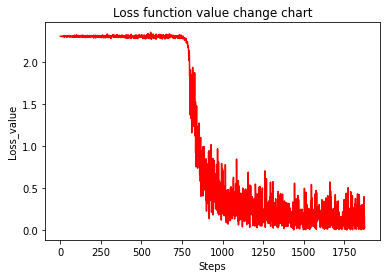

In [9]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

从上面可以看出来大致分为三个阶段：

阶段一：开始训练loss值在2.2上下浮动，训练收益感觉并不明显。

阶段二：训练到某一时刻，loss值减少迅速，训练收益大幅增加。

阶段三：loss值收敛到一定小的值后，loss值开始振荡在一个小的区间上无法趋0，再继续增加训练并无明显收益，至此训练结束。

##  测试数据验证模型精度

搭建测试网络的过程主要为：

1. 载入模型`.ckpt`文件中的参数`param`；
2. 将参数`param`载入到神经网络LeNet5中；
3. 载入测试数据集；
4. 调用函数`model.eval`传入参数测试数据集`ds_eval`，就生成模型`checkpoint_lenet-{epoch}_1875.ckpt`的精度值。

> `dataset_sink_mode`表示数据集下沉模式，不支持CPU，所以这里设置成`False`。

In [10]:
# testing relate modules 
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9669471153846154} ==============


经过1875步训练后生成的模型精度超过95%，模型优良。
我们可以看一下模型随着训练步数变化，精度随之变化的情况。

`eval_show`将绘制每25个`step`与模型精度值的折线图，其中`steps_eval`存储着模型的step数和对应模型精度值信息。

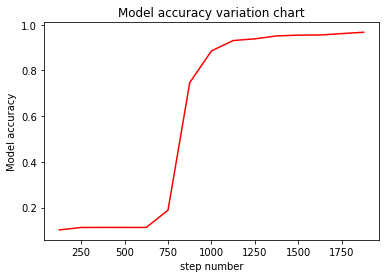

In [11]:
def eval_show(steps_eval):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(steps_eval["step"], steps_eval["acc"], "red")
    plt.show()

eval_show(steps_eval)

从图中可以看出训练得到的模型精度变化分为三个阶段：1、缓慢上升，2、迅速上升，3、缓慢上升趋近于不到1的某个值时附近振荡，说明随着训练数据的增加，会对模型精度有着正相关的影响，但是随着精度到达一定程度，训练收益会降低。

## 模型预测应用

我们尝试使用生成的模型应用到分类预测单个或者单组图片数据上，具体步骤如下：

1. 需要将要测试的数据转换成适应LeNet5的数据类型。
2. 提取出`image`的数据。
3. 使用函数`model.predict`预测`image`对应的数字。需要说明的是`predict`返回的是`image`对应0-9的概率值。
4. 调用`plot_pie`将预测的各数字的概率显示出来。负概率的数字会被去掉。

载入要测试的数据集并调用`create_dataset`转换成符合格式要求的数据集，并选取其中一组32张图片进行预测。

Row 3, column 8 is incorrectly identified as 7, the correct value should be 9 

Row 4, column 1 is incorrectly identified as 6, the correct value should be 5 

[1 7 0 5 0 2 8 4 6 2 3 0 3 1 3 4 5 3 9 6 6 2 1 7 6 6 6 4 4 3 0 7] <--Predicted figures
[1 7 0 5 0 2 8 4 6 2 3 0 3 1 3 4 5 3 9 6 6 2 1 9 5 6 6 4 4 3 0 7] <--The right number


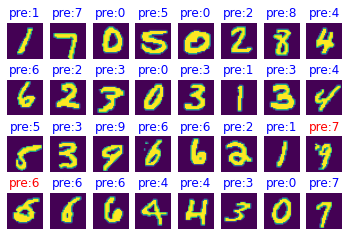

In [12]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures") 
print(labels, "<--The right number")
plt.show()

构建一个概率分析的饼图函数，本例展示了当前`batch`中的前两张图片的分析饼图。

备注：`prb`为上一段代码中，存储这组数对应的数字概率。

Figure 1 probability of corresponding numbers [0-9]:
 [-5.7945986   9.7789135   0.3184681  -2.5145538   1.3727839  -1.8544098
 -0.9416619  -0.27712426  0.5978755  -1.4200687 ]


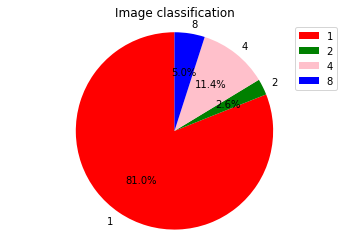

Figure 2 probability of corresponding numbers [0-9]:
 [-3.5296674  -1.4443045   0.55674577  1.7184858  -1.1003444  -3.0241313
 -7.969389   13.011139    0.46949214  1.3961829 ]


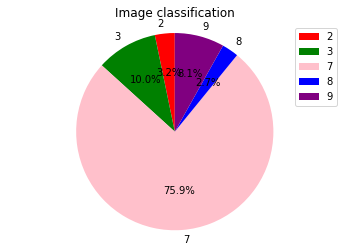

In [13]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"] 
    color = colors[: len(size)]
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()
    
    
for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i+1), prb[i])
    plot_pie(prb[i])

以上过程就是这次手写数字分类训练的全部体验过程。